<a href="https://colab.research.google.com/github/pablopsz/data_science/blob/main/Churn_Prediction_para_uma_empresa_de_Telecomunica%C3%A7%C3%B5es.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
<img alt="Colaboratory logo" width="15%" src="https://raw.githubusercontent.com/carlosfab/escola-data-science/master/img/novo_logo_bg_claro.png">

#### **Data Science na Prática 4.0**
*by [sigmoidal.ai](https://sigmoidal.ai)*  

---

# Churn Prediction

*Churn rate*, ou simplesmente *churn*, representa a taxa de evasão da sua base de clientes. Em serviços como Spotify ou Netflix, ela representaria a taxa de cancelamento de assinaturas.

<p align=center>
<img src="https://raw.githubusercontent.com/carlosfab/dsnp2/master/img/churnrate.jpg" width="60%"></p>

Ela é de extrema importância para a administração e sua análise ao longo do tempo pode mostrar que existe algum problema que deve ser atacado.

*Churn* também pode ser usado para identificar potenciais cancelamentos, com um tempo de antecedência, e promover ações direcionadas para tentar reter tais clientes. Essa métrica deve receber atenção pelo fato de que o Custo de Aquisição de Cliente (CAC) é normalmente mais alto que o custo para mantê-los. Ou seja, um alto valor para o *churn rate* é o que não desejamos.

## Aquisição dos Dados

Os dados utilizados neste projeto foram originalmente disponibilizados na [plataforma de ensino da IBM Developer](https://developer.ibm.com/technologies/data-science/patterns/predict-customer-churn-using-watson-studio-and-jupyter-notebooks/#), e tratam de um problema típico de uma companhia de telecomunicações. O *dataset* completo pode ser encontrado [neste link](https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv).

Apesar de não haver informações explícitas disponíves, os nomes das colunas permitem um entendimento a respeito do problema.

In [95]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

# importar os pacotes necessários
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from imblearn.under_sampling import RandomUnderSampler
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, classification_report, precision_score, recall_score

# importar os dados
DATA_PATH = "https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(DATA_PATH)

# ver as 5 primeiras entradas
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


 ## Análise Exploratória dos Dados
 Agora que vimos a cara dos nossos dados,vamos analisar agora algumas informações do dataset.

In [96]:
# dimensões do nosso dataset
print(f'Dimensões do dataset: {df.shape}\n')

# colunas e tipos das nossas variaveis
print(f'Variáveis do dataset:')
print(f'{df.info()}\n')

# valores faltantes por variavel
print(f'Valores nulos por variavel:\n{df.isnull().sum()/df.shape[0]}')

# quantidade unica de valores por variavel
print(f'Valores unicos por variavel: {df.nunique()}')

Dimensões do dataset: (7043, 21)

Variáveis do dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null  

Podemos ver que nossa variável 'TotalCharges' está como tipo 'object' quando na verdade representa valores. Vamos converter essa variável. Mas antes, vamos fazer um teste. Além disso, variáveis com poucos valores únicos (2 ou 3 valores) indicam variáveis categóricas. Essas serão transformadas posteriormente no projeto.

In [97]:
# verificar se e possivel converter a variavel
try:
  df["TotalCharges"].astype('float32')
except ValueError as e:
  print(f"Erro: {e}")

Erro: could not convert string to float: ' '


Por mais que não tenhamos valores nulos em nosso dataset, o valor ' ' foi utilizado para representar valores nulos nessa variável. Vamos criar uma função para converter os valores inputados e preencher os valores nulos por Nan. Vamos também preencher esses valores pela média da variável 'TotalCharges'.

In [98]:
def str_to_float(k):
  try:
    return float(k)
  except:
    return np.nan

# criar cópia do dataframe
df_clean = df.copy()

# remover coluna costumerID
df_clean.drop("customerID", axis=1, inplace=True)

# converter as strings de TotalCharges para float
df_clean["TotalCharges"] = df_clean["TotalCharges"].apply(str_to_float)

# substituir os dados ausentes pelo valor da mediana
TotalChargesMedian = df_clean.TotalCharges.median()
df_clean["TotalCharges"].fillna(TotalChargesMedian, inplace=True)

Nossos dados são majoritariamente categóricos. Quando analisamos nossos dados numéricos, podemos perceber que não há indícios de outliers.

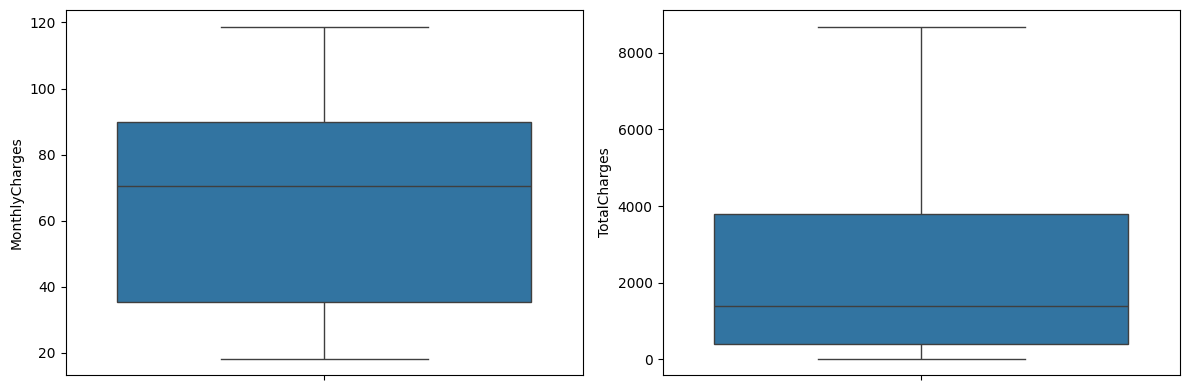

In [100]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
sns.boxplot(df_clean['MonthlyCharges'], ax=ax[0])
sns.boxplot(df_clean['TotalCharges'], ax=ax[1])
plt.tight_layout()

Vamos analisar agora os valores das nossas variáveis categóricas. Esse é um passo importante para entender o que está acontecendo nessas variáveis.

In [101]:
# verificar valores únicos das variáveis categóricas
np.unique(df_clean.select_dtypes('object').values)

array(['Bank transfer (automatic)', 'Credit card (automatic)', 'DSL',
       'Electronic check', 'Female', 'Fiber optic', 'Mailed check',
       'Male', 'Month-to-month', 'No', 'No internet service',
       'No phone service', 'One year', 'Two year', 'Yes'], dtype=object)

Voltando a atenção para nossa variável alvo agora, vamos ver como os dados dessa variável estão balanceados.

<Axes: xlabel='Churn', ylabel='count'>

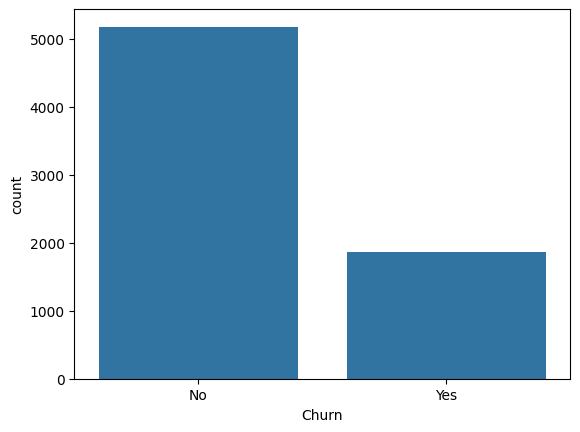

In [102]:
sns.countplot(data=df, x='Churn')

## Preparar os Dados
Podemos ver que temos uma quantidade desbalanceada de dados em nossa variável alvo. Esse problema será tratado posteriormente em nosso projeto. Agora, vamos separar nossas variáveis por tipo de variável e transformar essas de fato.

In [104]:
# pre processar as variaveis
binary_var = df_clean.nunique()[df_clean.nunique() == 2].keys().tolist()
num_var = [col for col in df_clean.select_dtypes(['int', 'float']).columns.tolist() if col not in binary_var]
cat_var = [col for col in df_clean.columns.tolist() if col not in binary_var + num_var]

# criar uma copia do dataframe
df_proc = df_clean.copy()

# Label Encoding para as variaveis Binarias
le = LabelEncoder()
for i in binary_var:
    df_proc[i] = le.fit_transform(df_proc[i])

# Encoding para colunas categóricas com multiplas classes
df_proc = pd.get_dummies(df_proc, columns=cat_var)

# ver as 5 primeiras entradas do novo dataframe
df_proc.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,1,29.85,29.85,0,...,1,0,0,1,0,0,0,0,1,0
1,1,0,0,0,34,1,0,56.95,1889.50,0,...,1,0,0,0,1,0,0,0,0,1
2,1,0,0,0,2,1,1,53.85,108.15,1,...,1,0,0,1,0,0,0,0,0,1
3,1,0,0,0,45,0,0,42.30,1840.75,0,...,1,0,0,0,1,0,1,0,0,0
4,0,0,0,0,2,1,1,70.70,151.65,1,...,1,0,0,1,0,0,0,0,1,0


## Modelo de Machine Learning
Tendo nossas variáveis transformadas, agora vamos separar nossos dados.

In [119]:
# separar a variável alvo dos demais dados
X = df_proc.drop('Churn', axis=1)
y = df_proc['Churn']

# dividir os dados entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y)

Vamos criar uma função para avaliar o desempenho do modelo selecionado. A métrica selecionada para avaliação é o 'recall'.

In [108]:
def val_model(X, y, modelo, quite=False):

    #criar pipeline
    pipeline = Pipeline([
        ('sacaler', StandardScaler()),
        ('model', modelo)
    ])

    # medir métrica de recall
    scores = cross_val_score(pipeline, X, y, scoring='recall')

    if quite == False:
        print("Recall: {:.2f} (+/- {:.2f})".format(scores.mean(), scores.std()))

    return scores.mean()

Vamos ver como um modelo de 'RandomForest' se sai com nossos dados.

In [109]:
# criar modelo e ver desempenho
rf = RandomForestClassifier()
score_baseline = val_model(X_train, y_train, rf)

Recall: 0.50 (+/- 0.04)


Dando andamento ao pré processamento dos dados, vamos padronizar esses e vamos também balancear os dados para que ambos os valores possíveis da nossa variável alvo tenham a mesma quantidade de entradas.

In [120]:
#  padronizar os  dados,
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

# realizar o balanceamento dos dados
rus = RandomUnderSampler()
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

Vamos testar diversos modelos em nossos dados e avaliar suas perfomaces.

In [111]:
# instanciar modelos
rf = RandomForestClassifier()
dt = DecisionTreeClassifier()
lr = LogisticRegression()
xgb = XGBClassifier()

model = []
recall = []

# avaliar o desempenho
for clf in (rf, dt, lr, xgb):
    model.append(clf.__class__.__name__)
    recall.append(val_model(X_train_rus, y_train_rus, clf, quite=True))

pd.DataFrame(data=recall, index=model, columns=['Recall'])

,Recall
RandomForestClassifier,0.750000
DecisionTreeClassifier,0.672535
LogisticRegression,0.796479
XGBClassifier,0.738732


Para atingir uma melhor perfomance, vamos tunar os parâmetros de nosso modelo. O modelo escolhido para esse projeto será o 'XGBoost'. Vamos utilizar a função 'GridSearchCV' para otimizar nossos parâmetros.

In [112]:
xgb = XGBClassifier(learning_rate=0.1)

param_grid = {
 'n_estimators':range(0,1000,50),
}

# identificar melhor parâmetro
kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

# ver resultados
print("Melhor: {} para {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor: 0.7711267605633803 para {'n_estimators': 50}


In [113]:
xgb = XGBClassifier(learning_rate=0.1, n_estimators=50)

param_grid = {
 'max_depth':range(1,8,1),
 'min_child_weight':range(1,5,1)
}

# identificar melhor parâmetro
kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

# ver resultados
print("Melhor: {} para {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor: 0.819718309859155 para {'max_depth': 1, 'min_child_weight': 1}


In [114]:
xgb = XGBClassifier(learning_rate=0.1, n_estimators=50, max_depth=1, min_child_weight=1)

param_grid = {
 'gamma':[i/10.0 for i in range(0,5)]
}

# identificar melhor parâmetro
kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

# ver resultados
print("Melhor: {} para {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor: 0.823943661971831 para {'gamma': 0.0}


In [115]:
xgb = XGBClassifier(n_estimators=50, max_depth=1, min_child_weight=1, gamma=0.0)

param_grid = {
 'learning_rate':[0.001, 0.01, 0.1, 1]
}

# identificar melhor parâmetro
kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

# ver resultados
print("Melhor: {} para {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor: 0.880281690140845 para {'learning_rate': 0.001}


Agora que temos os valores dos melhores parâmetros para nosso modelo, vamos de fato dar o 'fit' nos dados e realizar as predições da nossa variável alvo. Além disso, vamos ver algumas métricas de avaliação.

In [121]:
# modelo final
xgb = XGBClassifier(learning_rate=0.001 , n_estimators=50, max_depth=1, min_child_weight=1, gamma=0.0)
xgb.fit(X_train_rus, y_train_rus)

# fazer a previsão
X_test = scaler.transform(X_test)
y_pred = xgb.predict(X_test)

# Classification Report
print(classification_report(y_test, y_pred))

# imprimir a área sob a curva
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_pred)))

              precision    recall  f1-score   support

           0       0.93      0.54      0.68      1286
           1       0.42      0.88      0.57       475

    accuracy                           0.63      1761
   macro avg       0.67      0.71      0.62      1761
weighted avg       0.79      0.63      0.65      1761

AUC: 0.7123



<Axes: >

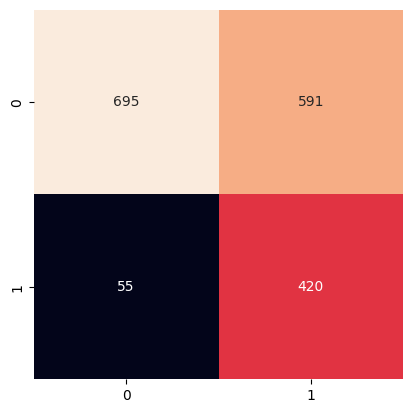

In [122]:
# criar a matriz de confusao
conf_matrix = confusion_matrix(y_test, y_pred)

# plotar o mapa de calor
sns.heatmap(conf_matrix, square=True, annot=True, cbar=False, fmt='d')

In [123]:
# instanciar as metricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# exibir as metricas
print(f'Acurácia: {accuracy:.4f}')
print(f'Precisão: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Acurácia: 0.6332
Precisão: 0.4154
Recall: 0.8842
F1 Score: 0.5653


## Conclusões
O cálculo de 'Churn' é um tipo de projeto muito comum e muito utilizado no mundo real por empresas do mundo todo. Dito isso, com poucas linhas pudemos chegar a um resultado aceitável, cabendo ainda mais melhorias, como por exemplo 'feature selection' e 'feature engineering'.